## This notebook is for Task 2 only

Improvements Task 2:

- Refer to one of the picture sent of whatsapp
- Could split chart into two/three views:
    + one is all wages, ranging from mininum to max
    + other is some wages, ranging from minimum to user-selected end point
    + And above two stack together vertically?
- Violin plots can zoom by changing the ranges
- Add another two more charts that are "weighted" by attribute 1 (one chart), attribute 2 (another chart), and these two could have selection filters on the wages violin plot
- Consider dropdown filter by region/country

In [1]:
# imports
import altair as alt
import pandas as pd
import sys
import os
# altair specific
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
# adds parent directory to this notebook, so it could use relative import
sys.path.append(os.path.dirname(os.getcwd()))

# user defined modules
from src.helpers import get_data


In [2]:
# read data here
data_path = "../data/player_raw_data.csv"
# this is raw data
fifa = get_data(data_path)
# this is processed for Task 5 specific
subset = get_data(data_path, preprocess=True)

>2. Discover distribution of wages by continent/country. Include weighted by skill/some attributes. 
>
> Those that do better would be paying their players more high std, should give pretty spread distributions



In [35]:
def attribute_histogram(data):
    # base histogram, add selector later
    attr_hist = alt.Chart(data).mark_bar().encode(
        x = alt.X("value:Q", bin=alt.Bin(maxbins=50), title=None),
        y=alt.Y('count()', title="Count of Records"),
        color = "region:N",
        tooltip=['value', 'count()', 'region']
    ).properties(
        width=600,
        height=600,
        title="Attribute Distribution"
    )
    
    return attr_hist

In [42]:
def wage_vio_plt(data):
    wage_violin = alt.Chart(data).transform_density(
        'wage',
        extent=[10_000, 250_000],
        as_=['wage', 'density'],
        groupby=['region', 'attribute']
    ).mark_area(orient='horizontal').encode(
        y=alt.Y('wage:Q', title="Wage (Euros) Weekly"),
        color=alt.Color('region:N', title="Region"),
        x=alt.X(
            'density:Q',
            stack='center',
            impute=None,
            title=None,
            axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
        ),
        column=alt.Column(
            'region:N',
            title="Region",
            header=alt.Header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
        ),
    ).properties(
        width=100,
        height=600,
        title="Wage Distribution By Region (Continent)"
    )
    
    return wage_violin

In [45]:
# using violet plot could be misleading, since max is 450_000, min is like 500
def task_two_viz(data):
    
    # get the attributes for options in the dropdown
    attributes = data.columns.tolist()[3:]
    attributes.remove("preferred_foot")
    attributes.remove('wage')
    # helper data to plot this attribute historgram
    helper_data = data.copy().melt(id_vars = ["country", "region", "wage"],  value_vars = attributes, var_name = "attribute", value_name = "value")
    
     # Click on the specfic Region
    click = alt.selection_multi(
        #empty='none',
        fields=['region'],
        bind='legend'
    )
    
    # Dropwdown menu, initial attribute is age
    dropdown = alt.selection_single(
        name="Select",
        init={"attribute": "age"},
        bind={"attribute": alt.binding_select(options=attributes),
             }
        )
    
    # slider
    brush = alt.selection_interval(
        encodings=["y"],
        resolve="global",
        empty="all"
    )

    # helper to create attribute histogram
    attr_hist = attribute_histogram(data=helper_data).add_selection(dropdown).add_selection(click).transform_filter(dropdown & brush & click)
    # helper to create wage violin plot
    wage_violin = wage_vio_plt(data=helper_data).encode(
        opacity = alt.condition(click, alt.value(1.0), alt.value(0.01))
    ).add_selection(brush).add_selection(click).transform_filter(dropdown)
    output = (attr_hist | wage_violin ).configure_facet(
       spacing=0
    ).configure_view(
       stroke=None
    )
    return output
t2_plot = task_two_viz(data=subset)

# Discover distribution of wages by continent/country and its interaction with specific attributes

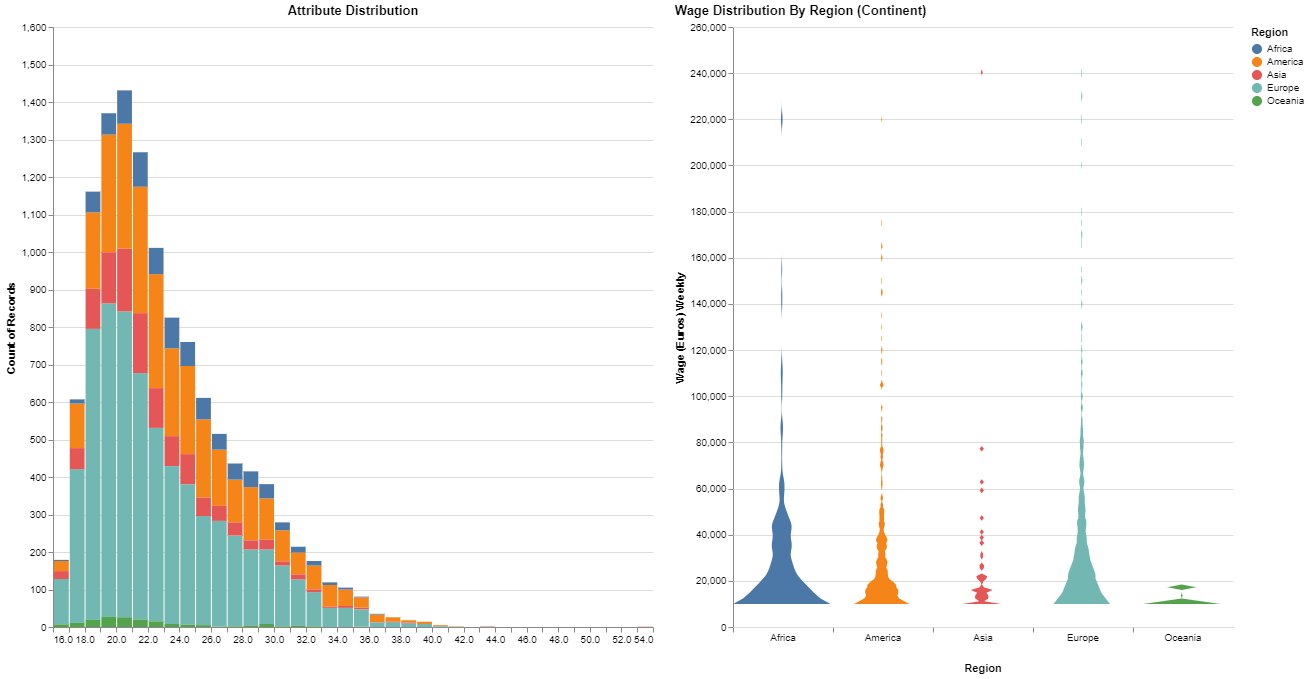

In [46]:
t2_plot